# Timeseries of GPM precipitation accumulation co-located with Colorado Landslide events

## Author: Jacquelyn Witte

In [1]:
import os
from glob import glob

import earthpy as et
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import seaborn as sns
import xarray as xr

import warnings
warnings.filterwarnings('ignore')

# Prettier plotting with seaborn
sns.set(font_scale=1.3, style="whitegrid")

#### Function to co-locate a landslide event with precipitation

In [2]:
def colocate_to_landslide(glc_df, datafiles, periods=7):
    """
    Returns a dataframe of precipitation values colocated to a landslide event.
    
    Based on the Global Landslide Catalog as input.
    Define the number of day to retrieve a precipitation value leading up
        to a landslide event.
        
    Parameters 
    ----------
    
    glc_df: pandas.core.frame.DataFrame
        The GLC dataframe
    
    datafiles: List string
        GPM path to all the files
        
    period: int
        Number of periods to generate. Default is 7 days.

    Returns
    -------
    df: pandas.core.frame.DataFrame 
    """
    ld = []
    precip = []
    landslide_id = []
    landslide_cat = []
    landslide_trig = []
    landslide_sz = []
    lat = []
    lon = []
    periods = 7
    count_down = []
    
    for i, date in enumerate(glc_df.index):
        #seven_days = pd.date_range(date, periods=periods, freq='-1D')
        seven_days = pd.date_range(date, periods=periods, freq='-1D').strftime('%Y%m%d')
    
        countd = periods
    
        for day in seven_days:
            # date in format to match with filenames
            #ldate = "".join(str(day).split(' ')[0].split('-'))
            #ld.append(ldate)
            ld.append(day)
    
            # find the files 
            file = [x for x in datafiles if re.findall(day, x)]
    
            # read the file
            data_xr = xr.open_dataset(file[0]).squeeze()
    
            # subset the file
            precip.append(data_xr['precipitationCal'].sel(indexers={
                    'lon': glc_df.longitude[i],
                    'lat': glc_df.latitude[i]},
                    method="nearest"))
    
            #print(i, glc_co.longitude[i], glc_co.latitude[i])
    
            lat.append(glc_df.latitude[i])
            lon.append(glc_df.longitude[i])
    
            # Append landslide metadata
            landslide_id.append(glc_df.event_id[i])
            landslide_cat.append(glc_df.landslide_category[i])
            landslide_trig.append(glc_df.landslide_trigger[i])
            landslide_sz.append(glc_df.landslide_size[i])
    
            # Append countdown
            count_down.append(countd)
            countd -=1
    
    
    df = pd.DataFrame(precip, 
                      index= pd.to_datetime(ld), columns=['precip_mm'])
    df['lat'] = lat
    df['lon'] = lon
    df['landslide_id'] = landslide_id
    df['landslide_category'] = landslide_cat
    df['landslide_trigger'] = landslide_trig
    df['landslide_size'] = landslide_sz
    df['days-to-landslide'] = count_down
    
    return df

#### Calculated the cumulative precipitation

In [3]:
def cumulative_precip(df):
    """
    Add a column of accumulated precipitation
    
    Parameters
    ----------
    df: pandas.core.frame.DataFrame

    Returns
    -------
    pandas.core.frame.DataFrame plus added column
    """
    
    accum = []
    for i, data in df.groupby("landslide_id"):
        accum.extend(np.flip(data['precip_mm'].cumsum().values))

    df['precip_accum_mm'] = accum
    return df

#### Change directory to where all the Capstone data reside

In [4]:
data_dir = os.path.join(et.io.HOME,
                        'earth-analytics',
                        'data', 'capstone')
os.chdir(data_dir)

#### Read and subset to Colorado Landslides

In [5]:
glc_file = os.path.join('landslide', 'landslides.verified.csv')
glc = pd.read_csv(glc_file)

In [6]:
glc_file = os.path.join('landslide', 'nasa.glc.export.csv')
os.path.exists(glc_file)

glc = pd.read_csv(glc_file)

glc_co = glc[(glc['country_code'] == 'US') & (
                                glc['admin_division_name'] == 'Colorado') & (
                                glc['landslide_trigger'] != 'freeze_thaw') &(
                            glc['landslide_trigger'] != 'snowfall_snowmelt')
            ]
# covert to datetime
glc_co['date'] = pd.to_datetime(glc_co['event_date'])
glc_co = glc_co.set_index('date').sort_index()
glc_co.head()

,source_name,source_link,event_id,event_date,event_time,event_title,event_description,location_description,location_accuracy,landslide_category,...,country_code,admin_division_name,admin_division_population,gazeteer_closest_point,gazeteer_distance,submitted_date,created_date,last_edited_date,longitude,latitude
date,,,,,,,,,,,,,,,,,,,,,
2007-06-01,Sky-Hi News,http://www.skyhidailynews.com/news/13393638-11...,6253,6/1/07 0:00,NaN,Granby landfill,"All in all, the county has spent over $7 milli...",Granby landfill,5km,landslide,...,US,Colorado,1864.0,Granby,5.53226,10/17/14 19:11,11/20/17 15:17,2/15/18 15:51,-105.8752,40.0929
2007-08-14,Telluride Daily Planet,http://www.telluridegateway.com/articles/2007/...,185,8/14/07 0:00,NaN,"Tellride, CO, Hwy 145",Tues afternoon 4pm,"Tellride, CO, Hwy 145",10km,mudslide,...,US,Colorado,2475.0,Meeker,10.87949,4/1/14 0:00,11/20/17 15:17,2/15/18 15:51,-107.8818,39.9425
2007-09-06,Craigdailypress.com,http://www.craigdailypress.com/news/2007/sep/0...,238,9/6/07 0:00,NaN,"River and Mt Warner Road, Steamboat Springs, CO","slide 75 feet down hill carrying trees, etc. o...","River and Mt Warner Road, Steamboat Springs, CO",1km,mudslide,...,US,Colorado,12088.0,Steamboat Springs,2.63588,4/1/14 0:00,11/20/17 15:17,2/15/18 15:51,-106.8295,40.4613
2007-09-17,KJCT news,http://kjct8.com/Global/story.asp?S=7085534,268,9/17/07 0:00,NaN,"I-70 between New Castle and Silt, Colorado",mudslides and flooding on road in early and mi...,"I-70 between New Castle and Silt, Colorado",5km,mudslide,...,US,Colorado,4518.0,New Castle,4.25758,4/1/14 0:00,11/20/17 15:17,2/15/18 15:51,-107.5798,39.5542
2008-04-13,vaildaily,http://www.vaildaily.com/article/20080428/NEWS...,499,4/13/08 0:00,NaN,U.S. Highway 6 between Kayak Crossing apartmen...,"A mudslide buried a lane, crushed a metal reta...",U.S. Highway 6 between Kayak Crossing apartmen...,5km,mudslide,...,US,Colorado,6447.0,Avon,3.03321,4/1/14 0:00,11/20/17 15:17,2/15/18 15:51,-106.4879,39.6250


In [7]:
print('The Columns names of the GLC are:')
glc_co.columns

The Columns names of the GLC are:


Index(['source_name', 'source_link', 'event_id', 'event_date', 'event_time',
       'event_title', 'event_description', 'location_description',
       'location_accuracy', 'landslide_category', 'landslide_trigger',
       'landslide_size', 'landslide_setting', 'fatality_count', 'injury_count',
       'storm_name', 'photo_link', 'notes', 'event_import_source',
       'event_import_id', 'country_name', 'country_code',
       'admin_division_name', 'admin_division_population',
       'gazeteer_closest_point', 'gazeteer_distance', 'submitted_date',
       'created_date', 'last_edited_date', 'longitude', 'latitude'],
      dtype='object')

#### Gather the GPM data files

In [28]:
gpm_files = sorted(glob(os.path.join('gpm_old', '*nc4')))
len(gpm_files)

4049

In [34]:
data_xr = xr.open_dataset(gpm_files[10]).squeeze()
res = data_xr['precipitationCal'].sel(indexers={
                    'lon': glc_co.longitude[10],
                    'lat': glc_co.latitude[10]},
                    method="nearest")
float(res.values)

0.029999995604157448

#### Read GPM data for each Landslide event
- Use nearest-neighbor approach
- Calculate the accumulated precipitations for 7 days prior to each landslide.
- <u>NOTE</u> The actual dimensions are `[time, lon, lat]`
- The variable we want is named `precipitationCal`
    - long_name : Daily accumulated precipitation (combined microwave-IR) estimate
    - units : mm

In [9]:
gpm_7days_df = colocate_to_landslide(glc_co, gpm_files, periods=7)

In [10]:
# Add the accummulate precipitaton
gpm_7days_df = cumulative_precip(gpm_7days_df)

gpm_7days_df

,precip_mm,lat,lon,landslide_id,landslide_category,landslide_trigger,landslide_size,days-to-landslide,precip_accum_mm
2007-06-01,0.064783,40.0929,-105.8752,6253,landslide,unknown,medium,7,10.259658
2007-05-31,0.661531,40.0929,-105.8752,6253,landslide,unknown,medium,6,10.259658
2007-05-30,0.017648,40.0929,-105.8752,6253,landslide,unknown,medium,5,10.259658
2007-05-29,5.893072,40.0929,-105.8752,6253,landslide,unknown,medium,4,10.259658
2007-05-28,0.000000,40.0929,-105.8752,6253,landslide,unknown,medium,3,10.259658
...,...,...,...,...,...,...,...,...,...
2016-10-17,0.103815,38.9833,-107.3476,9660,rock_fall,unknown,medium,5,0.146685
2016-10-16,0.029013,38.9833,-107.3476,9660,rock_fall,unknown,medium,4,0.146685
2016-10-15,0.000000,38.9833,-107.3476,9660,rock_fall,unknown,medium,3,0.117671
2016-10-14,0.188817,38.9833,-107.3476,9660,rock_fall,unknown,medium,2,0.013857


#### Plot cumulative precip going back 7 days

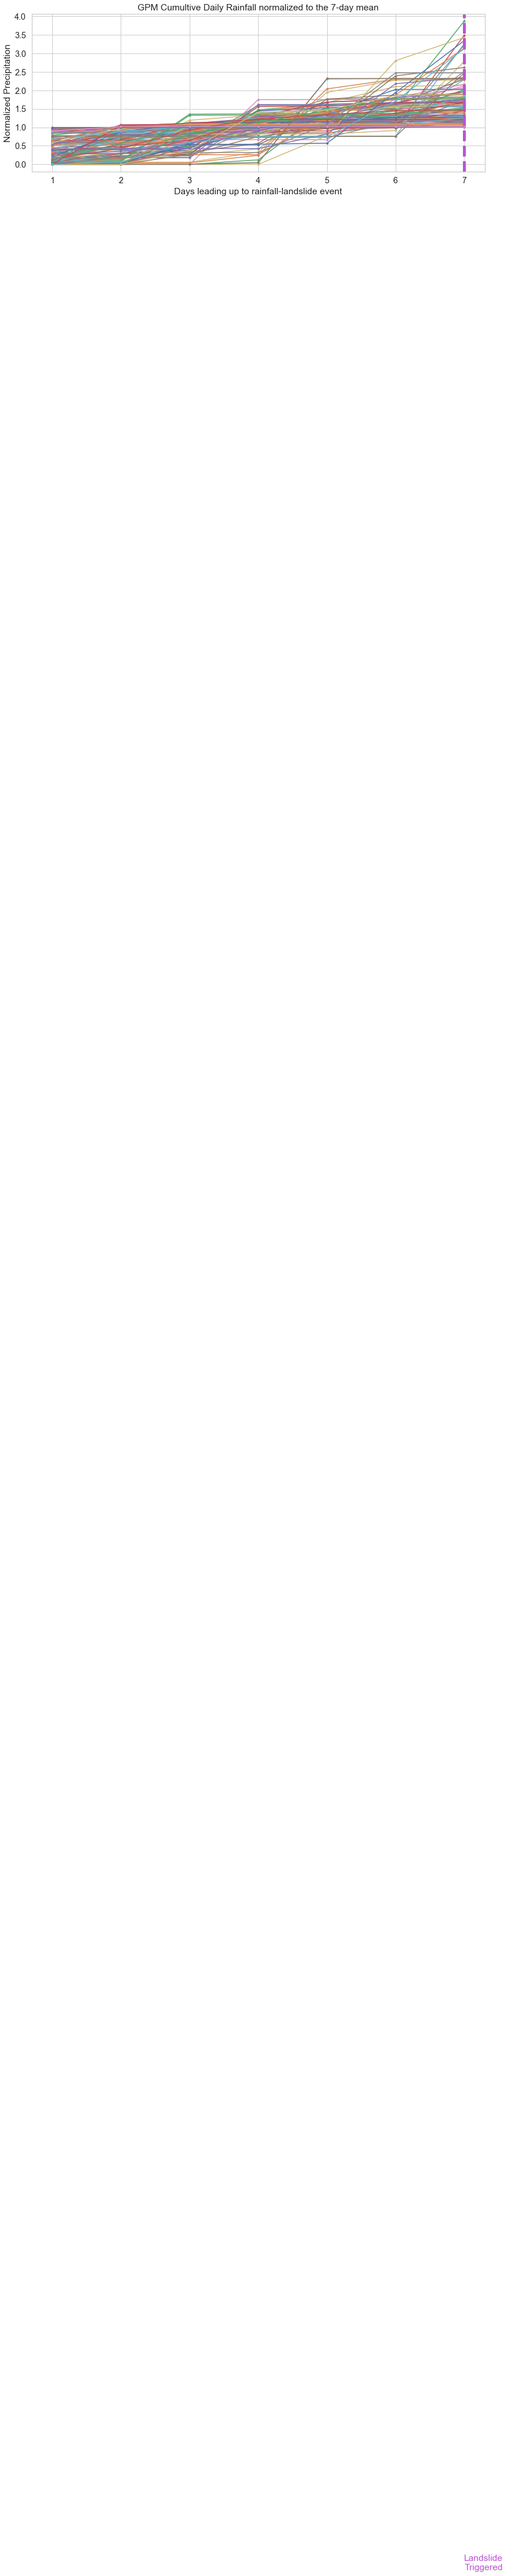

In [26]:
fig, ax = plt.subplots(figsize=(14, 5), sharex=True, sharey=True)

for id, df in gpm_7days_df.groupby("landslide_id"):
    ax.plot(df['days-to-landslide'], 
            df['precip_accum_mm']/df['precip_accum_mm'].mean(), 
            marker='.')

#ax.invert_xaxis()
ax.axvline(x=7, ymin=0, color='mediumorchid', linestyle='dashed', linewidth=5)
#ax.set_xlim([-30,-0.5])
ax.set(xlabel='Days leading up to rainfall-landslide event',
       ylabel='Normalized Precipitation',
       title='GPM Cumultive Daily Rainfall normalized to the 7-day mean')
ax.text(7,-65, 'Landslide\nTriggered', color='mediumorchid', fontsize='medium');

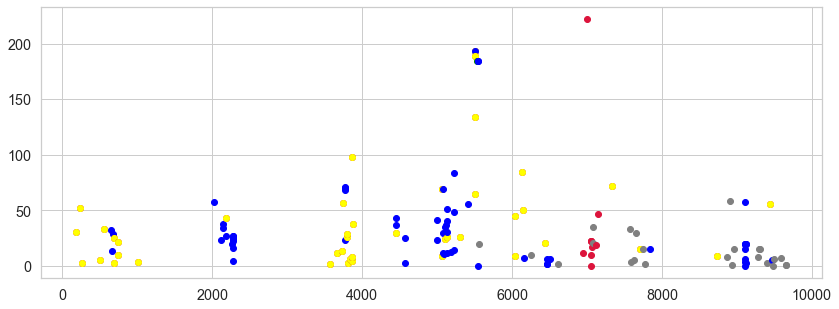

In [12]:
colors = ['crimson', 'blue', 'yellow', 'green', 'gray']

# get the summary of unique road types
keys = np.unique(gpm_7days_df['landslide_trigger'])

# create a dictionary of keys:color pairs
trigger_colors = dict(zip(keys.tolist(), colors[0:len(keys)]))
trigger_colors

fig, ax = plt.subplots(figsize=(14, 5))

for id, data in gpm_7days_df.groupby('landslide_id'):
    for k in keys:
        if data['landslide_trigger'][0] in k:
            ax.plot(id, data['precip_accum_mm'].max(),
                   color=trigger_colors[k],
                   marker='o',
                   label=k)


### Calculated precipitation statistics

In [13]:
gpm_7days_df.head()

,precip_mm,lat,lon,landslide_id,landslide_category,landslide_trigger,landslide_size,days-to-landslide,precip_accum_mm
2007-06-01,0.064783,40.0929,-105.8752,6253,landslide,unknown,medium,7,10.259658
2007-05-31,0.661531,40.0929,-105.8752,6253,landslide,unknown,medium,6,10.259658
2007-05-30,0.017648,40.0929,-105.8752,6253,landslide,unknown,medium,5,10.259658
2007-05-29,5.893072,40.0929,-105.8752,6253,landslide,unknown,medium,4,10.259658
2007-05-28,0.000000,40.0929,-105.8752,6253,landslide,unknown,medium,3,10.259658


In [14]:
gpm_7day_stats = gpm_7days_df.groupby('landslide_id').agg({'precip_mm': ['min', 'max', 'mean', 'median']})
gpm_7day_stats.columns = gpm_7day_stats.columns.map('_'.join)
gpm_7day_stats

,precip_mm_min,precip_mm_max,precip_mm_mean,precip_mm_median
landslide_id,,,,
185,0.000000,8.881645,1.465665,0.000000
238,0.000000,22.166019,4.368387,0.622293
268,0.000000,48.704182,7.502234,0.257306
499,0.000000,1.531000,0.359171,0.014200
555,0.029462,3.703404,0.736687,0.193446
...,...,...,...,...
9486,0.000000,3.168258,0.781161,0.393921
9497,0.000000,0.379923,0.055361,0.000000
9586,0.000000,5.776446,0.939597,0.000000


### Plot the distribution of the statistics

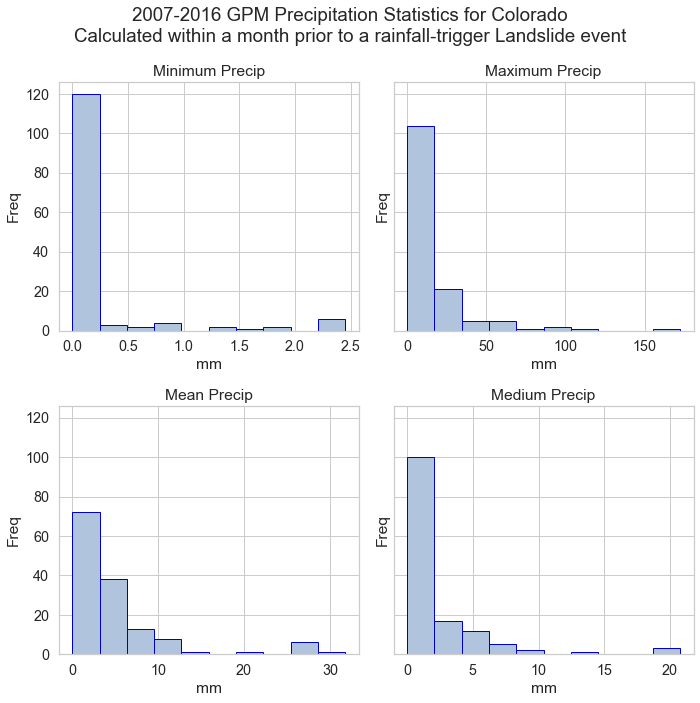

In [15]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(ncols=2, nrows=2, 
                                         figsize=(10, 10),
                                         sharey=True)
# Add overall figure title
tit1 = '2007-2016 GPM Precipitation Statistics for Colorado'
tit2 = 'Calculated within a month prior to a rainfall-trigger Landslide event'
fig.suptitle(tit1+'\n'+tit2)


# the histogram of the data
gpm_7day_stats['precip_mm_min'].hist(ax=ax1, 
                              color='lightsteelblue', edgecolor='mediumblue')
gpm_7day_stats['precip_mm_max'].hist(ax=ax2,
                              color='lightsteelblue', edgecolor='mediumblue')
gpm_7day_stats['precip_mm_mean'].hist(ax=ax3,
                              color='lightsteelblue', edgecolor='mediumblue')
gpm_7day_stats['precip_mm_median'].hist(ax=ax4,
                              color='lightsteelblue', edgecolor='mediumblue')

ax1.set(xlabel='mm', ylabel='Freq',
        title='Minimum Precip');
ax2.set(xlabel='mm', ylabel='Freq',
        title='Maximum Precip');
ax3.set(xlabel='mm', ylabel='Freq',
        title='Mean Precip');
ax4.set(xlabel='mm', ylabel='Freq',
        title='Medium Precip');

fig.tight_layout()

#### Plot the 14 day histogram

In [16]:
# fig, ax = plt.subplots(figsize=(10, 6),sharex=True, sharey=True)

# for id, df in gpm_7days_df.groupby("landslide_id"):
#     ax.hist(df.precip_mm)

# ax.set(ylabel='Frequency',
#        xlabel='Precipitation [mm]',
#        title='GPM 14 Day Rainfall');

#### Export to a CSV file

In [17]:
#gpm_7days_df.to_csv(os.path.join('capstone', 'gpm', 'gpm_2007-2016_co_7days.csv'))
#gpm_14days_df.to_csv(os.path.join('capstone', 'gpm', 'gpm_2007-2016_co_14days.csv'))
#gpm_30days_df.to_csv(os.path.join('capstone', 'gpm', 'gpm_2007-2016_co_30days.csv'))